# Загружаем фотографии и маски

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import torch
import torchvision
import tensorflow as tf
from keras import backend as K

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving dataset.zip to dataset.zip


In [ ]:
import os
os.mkdir("/content/sample_data/BTS Test")
os.mkdir("/content/sample_data/BTS Test/dataset_aug")
os.mkdir("/content/sample_data/BTS Test/dataset_aug/imgs")
os.mkdir("/content/sample_data/BTS Test/dataset_aug/masks")

In [ ]:
print(os.listdir("/content/sample_data/BTS Test/"))

# Any results you write to the current directory are saved as output.

import zipfile
with zipfile.ZipFile('/content/dataset.zip', 'r') as zip_obj:
   # Extract all the contents of zip file in current directory
   zip_obj.extractall('/content/sample_data/BTS Test/')
    
print('After zip extraction:')
print(os.listdir("/content/sample_data/BTS Test/"))

['dataset_aug', 'final_df.csv']
After zip extraction:
['dataset_aug', 'final_df.csv', 'dataset']


In [ ]:
df_original = pd.read_csv('/content/sample_data/BTS Test/final_df.csv')
df_original[:5]

,Unnamed: 0,img,rle_mask
0,0,Image0001.jpg,Image0001.png
1,1,Image0002.jpg,Image0002.png
2,2,Image0003.jpg,Image0003.png
3,3,Image0004.jpg,Image0004.png
4,4,Image0005.jpg,Image0005.png


#Проверяем фотографии, точнее их маски на схожесть
Сгрупируем фотки по одинаковости, чтобы смогли отделить данные для тренинга и валидации

In [ ]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [ ]:
def dice_coef(y_true, y_pred, smooth=0.1):
 intersection = K.sum(y_true * y_pred)
 union = K.sum(y_true) + K.sum(y_pred)
 dice = K.mean((2. * intersection + smooth)/(union + smooth))
 return dice

In [ ]:
group_of_odin = []
spisok_ = []
for imm in range(0,240):
  hh, img_name_1, mask_rle_1 = df_original.iloc[imm]
  group_of_imm = [imm]
  if imm not in spisok_:
    for inn in range(imm+1, 240):
      if inn not in spisok_:
        hh, img_name_2, mask_rle_2 = df_original.iloc[inn]
        mask_1 = cv2.imread('/content/sample_data/BTS Test/dataset/masks/{}'.format(mask_rle_1))
        mask_2 = cv2.imread('/content/sample_data/BTS Test/dataset/masks/{}'.format(mask_rle_2))
        mask_1 = (mask_1[:,:,0]>122).astype('int')
        mask_2 = (mask_2[:,:,0]>122).astype('int')

        odinakov = dice_coef(y_true=mask_1, y_pred=mask_2)

        if odinakov*100. > 82.:
          spisok_.append(inn)
          spisok_.append(imm)
          group_of_imm.append(inn)
          #print(mask_rle_1, mask_rle_2, odinakov)
    group_of_odin.append(group_of_imm)

In [ ]:
print(len(group_of_odin))

20


In [ ]:
group_of_odin[-12:-8] #порядковые номера схожих масок

[[8, 18, 28, 38, 48, 58, 68, 78, 88, 98, 108, 118, 128, 138, 148, 158],
 [9, 19, 29, 39, 49, 59, 69, 79, 89, 99, 109, 119, 129, 139, 149, 159],
 [160, 170, 180, 190, 200, 210, 220, 230],
 [161, 171, 181, 191, 201, 211, 221, 231]]

In [ ]:
for imm in range(0,240):
  if imm not in spisok_:
    print(imm)

Вывод: видим что много схожих масок по коэффициенту Dice cofficient, всего 20 групп различных масок (по 8 или 16 масок в группе). 
Поделим train и val чтобы модель не тренировалась и валидировалась на одинаковых фотках.

In [ ]:
train_numb = []
val_numb = []
for imm in range(20):
  if imm == 3 or imm == 5:
    val_numb += group_of_odin[imm]
  else:
    train_numb += group_of_odin[imm]
print('масок для валидации', len(val_numb))
print('масок для тренировки', len(train_numb))

масок для валидации 32
масок для тренировки 208


# Здесь делаем аугментацию

In [ ]:
from albumentations import (
    CLAHE, RandomRotate90, CenterCrop , Transpose, RandomCrop, Resize, ShiftScaleRotate, Blur, OpticalDistortion, 
    GridDistortion, HueSaturationValue, IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, 
    MedianBlur, IAAPiecewiseAffine, IAASharpen, IAAEmboss, RandomContrast, RandomBrightness, 
    Flip, HorizontalFlip, VerticalFlip, OneOf, Compose, PadIfNeeded, LongestMaxSize, PadIfNeeded, ElasticTransform,Cutout
)

In [ ]:
from albumentations import (Crop, RandomRotate90, HorizontalFlip, VerticalFlip, Rotate, 
                            RandomBrightnessContrast, RGBShift)

In [ ]:
import random

In [220]:
train_val_numb[:4]

[0, 10, 20, 30]

In [ ]:
p_ver = [[0, 0, 0], [0, 0, 1], [0, 1, 0], [0, 1, 1], [1, 0, 0], [1, 0, 1], [1, 1, 0], [1, 1, 1]]
train_val_numb = train_numb+val_numb
nomer_img = 0
for imm in train_val_numb:

  hh, img_name, mask_rle = df_original.iloc[imm]
  print(img_name, mask_rle)
  img = cv2.imread('/content/sample_data/BTS Test/dataset/imgs/{}'.format(img_name)).astype('uint8')
  mask = cv2.imread('/content/sample_data/BTS Test/dataset/masks/{}'.format(mask_rle)).astype('uint8')
  data = {'image': img, 'mask': mask}
  
  for inn in range(3):
    
    dlina_sq = 320
    x_min = 100 + inn*50 + random.randint(-12, 12)
    y_min = [576-dlina_sq, int((576-dlina_sq)/2), 0][inn]
    
    if inn == 1:
      augmented_crop_1 = Crop(x_min=x_min-74, y_min=y_min-74, 
                              x_max=x_min+dlina_sq+128, y_max=y_min+dlina_sq+128, always_apply=True)(**data)
      crop_img_crop_1, crop_mask_crop_1 = augmented_crop_1["image"], augmented_crop_1["mask"]
      
      data_rot =  {'image': crop_img_crop_1, 'mask': crop_mask_crop_1}
      augmented_rot = Rotate(limit=[30,60], always_apply=True)(**data_rot)
      crop_img_rot, crop_mask_rot = augmented_rot["image"], augmented_rot["mask"]
      
      data_cent =  {'image': crop_img_rot, 'mask': crop_mask_rot}
      augmented_cent = CenterCrop(dlina_sq, dlina_sq, always_apply=True)(**data_cent)
      crop_img, crop_mask = augmented_cent["image"], augmented_cent["mask"]

    else:
      augmented = Crop(x_min=x_min, y_min=y_min, x_max=x_min+dlina_sq, y_max=y_min+dlina_sq, always_apply=True)(**data)
      crop_img, crop_mask = augmented["image"], augmented["mask"]
      
    #print(mask[:,:,0])
    #print(sum(sum(sum(crop_mask))))

    for ipp in range(8):
      data_bri = {'image': crop_img, 'mask': crop_mask}
      augmented_bri = RandomBrightnessContrast(p=0.3)(**data_bri)
      crop_img_bri, crop_mask_bri = augmented_bri["image"], crop_mask 

      data_rgb = {'image': crop_img_bri, 'mask': crop_mask_bri}   
      augmented_rgb = RGBShift (p=0.2)(**data_rgb)
      crop_img_rgb, crop_mask_rgb = augmented_rgb["image"], crop_mask_bri

      p_ver_ipp = p_ver[ipp]
      
      data_0 = {'image': crop_img_rgb, 'mask': crop_mask_rgb}
      if p_ver_ipp[0] == 1:
        #print(90)
        augmented_90 = Rotate(limit=[90,90], always_apply=True)(**data_0)
        crop_img_90, crop_mask_90 = augmented_90["image"], augmented_90["mask"]
      else:
        crop_img_90, crop_mask_90 = crop_img_bri, crop_mask_bri 

      data_1 = {'image': crop_img_90, 'mask': crop_mask_90}  
      if p_ver_ipp[1] == 1:
        augmented_ver =  VerticalFlip(always_apply=True)(**data_1)
        crop_img_ver, crop_mask_ver = augmented_ver["image"], augmented_ver["mask"]
      else:
        crop_img_ver, crop_mask_ver = crop_img_90, crop_mask_90
      
      data_2 = {'image': crop_img_ver, 'mask': crop_mask_ver}  
      if p_ver_ipp[2] == 1:
        augmented_hor =  HorizontalFlip(always_apply=True)(**data_2)
        crop_img_hor, crop_mask_hor = augmented_hor["image"], augmented_hor["mask"]
      else:
        crop_img_hor, crop_mask_hor = crop_img_ver, crop_mask_ver
      
      #print(nomer_img) 
      cv2.imwrite('/content/sample_data/BTS Test/dataset_aug/imgs/{}'.format(str(nomer_img)+'.jpg'), crop_img_hor)
      cv2.imwrite('/content/sample_data/BTS Test/dataset_aug/masks/{}'.format(str(nomer_img)+'.png'), crop_mask_hor)
      nomer_img += 1
      
      #print(sum(sum(sum(crop_mask_hor))), crop_mask_hor.shape)
      #fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 5))
      #axes[0].imshow(crop_img_hor[..., [2,1,0]])
      #axes[1].imshow(crop_mask_hor)
      #plt.show()

## Черновики

In [ ]:
def strong_aug(p=1.0):
    return Compose([
        CenterCrop(576, 576, always_apply=True),
        ShiftScaleRotate(shift_limit=0.2, scale_limit=0, rotate_limit=10, p=0.2, border_mode=cv2.BORDER_CONSTANT),
        RandomCrop(256, 256),
        #PadIfNeeded(min_height=224, min_width=224, border_mode=cv2.BORDER_CONSTANT, p=1.0),
        #Resize(64, 64),
        RandomRotate90(p=0.5),
        ElasticTransform(p=0.5), 
        HorizontalFlip(p=0.5),
        VerticalFlip(p=0.5),
        #Flip(p=0.1),
        RandomBrightness(p=0.2)], p=p)
        #Cutout(p=1.),
        #Transpose(),

In [ ]:
hh, img_name, mask_rle = df_original.iloc[1]

img = cv2.imread('/content/sample_data/BTS Test/dataset/imgs/{}'.format(img_name))
mask = cv2.imread('/content/sample_data/BTS Test/dataset/masks/{}'.format(mask_rle))
#mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)#.astype(np.float32)
augmentation = strong_aug(p=1.0)


data = {'image': img.astype('uint8'), 'mask': mask}
augmented = augmentation(**data)
crop_img, crop_mask = augmented["image"], augmented["mask"]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
axes[0].imshow(crop_img[..., [2,1,0]])
axes[1].imshow(crop_mask)

plt.show()

In [ ]:
# на это ушло 6мин 4сек
for imm in range(240):
  if imm%10 ==0:
    print(imm)
  hh, img_name, mask_rle = df_original.iloc[imm]

  img = cv2.imread('/content/sample_data/BTS Test/dataset/imgs/{}'.format(img_name)).astype('uint8')
  mask = cv2.imread('/content/sample_data/BTS Test/dataset/masks/{}'.format(mask_rle))
  data = {'image': img, 'mask': mask}
  inn = 0
  while inn < 20:
    augmentation = strong_aug(p=1.0)
    augmented = augmentation(**data)
    crop_img, crop_mask = augmented["image"], augmented["mask"]
    if sum(sum(sum(crop_mask))) > 250:
      cv2.imwrite('/content/sample_data/BTS Test/dataset_aug/imgs/{}'.format(str(20*imm++inn)+'.jpg'), crop_img)
      cv2.imwrite('/content/sample_data/BTS Test/dataset_aug/masks/{}'.format(str(20*imm+inn)+'.png'), crop_mask)
      inn+=1

# Создаём модель для семантической сегментации

In [ ]:
pip install -U segmentation-models

In [ ]:
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [ ]:
pip install -U keras

In [ ]:
df = pd.DataFrame([[str(x)+'.jpg', str(x)+'.png'] for x in range(240*24)], 
                  columns=['img', 'rle_mask']) 
#df = pd.read_csv('/content/sample_data/BTS Test/final_df.csv')
df.shape

(5760, 2)

In [ ]:
train_df = df[:210*24] # для тренировок выбрал не 208 фоток как планировалось а 210, чтобы было кратно размеру батча 10
val_df = df[210*24:]

In [ ]:
val_df.shape

(720, 2)

Посмотрим как выглядят тренировочные фотографии и их маски

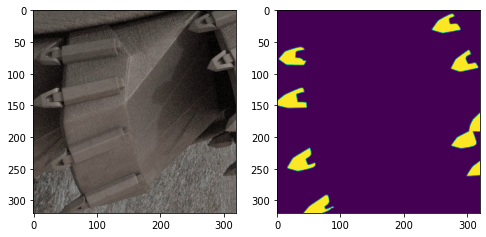

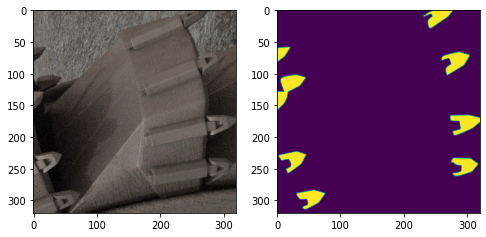

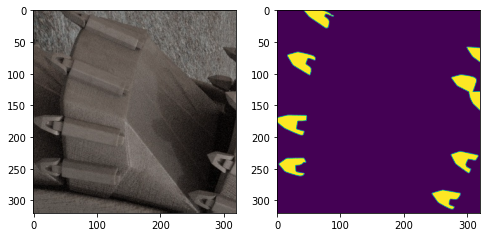

In [228]:
for numim in range(5, 8):
  img_name, mask_rle = train_df.iloc[numim]

  img = cv2.imread('/content/sample_data/BTS Test/dataset_aug/imgs/{}'.format(img_name))
  mask = cv2.imread('/content/sample_data/BTS Test/dataset_aug/masks/{}'.format(mask_rle))
  mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY).astype(np.float32)
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))

  axes[0].imshow(img)
  axes[1].imshow(mask)

plt.show()

In [229]:
img.shape

(320, 320, 3)

In [ ]:
def keras_generator(gen_df, batch_size):
    while True:
        x_batch = []
        y_batch = []
        #rows, cols = 256, 256
        #M = np.float32([[1,0,-180],[0,1,-120]])
        
        for i in range(batch_size):
            img_name, mask_rle = gen_df.sample(1).values[0]
            img = cv2.imread('/content/sample_data/BTS Test/dataset_aug/imgs/{}'.format(img_name))
            mask = cv2.imread('/content/sample_data/BTS Test/dataset_aug/masks/{}'.format(mask_rle))
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY).astype(np.float32)  

            #img = cv2.resize(img, (256, 256))
            #mask = cv2.resize(mask, (256, 256))
            
            #img = cv2.warpAffine(img,M,(cols,rows)) 
            #mask = cv2.warpAffine(mask,M,(cols,rows))

            x_batch += [img]
            y_batch += [mask]

        x_batch = np.array(x_batch) / 255.
        y_batch = np.array(y_batch) / 255.

        yield x_batch, np.expand_dims(y_batch, -1)

In [ ]:
for x, y in keras_generator(val_df, 20):
    break

In [ ]:
print(x.shape, y.shape)
#x, y = 0, 0

(20, 320, 320, 3) (20, 320, 320, 1)


In [ ]:
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

'tf.keras'

In [230]:
import keras
#from kerasapplications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D, Concatenate, Activation


# create the base pre-trained model
base_model = tf.keras.applications.ResNet50(weights='imagenet', input_shape=(320,320,3), include_top=False)
 
base_out = base_model.output

# up = UpSampling2D(size=(32, 32), data_format=None, interpolation='bilinear')(base_out)
# up = Conv2D(1, (1,1), strides=(1, 1))(up)


# model = Model(input=base_model.input, output=up)

In [ ]:
base_model.summary()

In [231]:
conv1 = base_model.get_layer('conv1_relu').output
conv2 = base_model.get_layer('conv2_block3_out').output
conv3 = base_model.get_layer('conv3_block4_2_relu').output
conv4 = base_model.get_layer('conv4_block6_2_relu').output
conv5 = base_model.get_layer('conv5_block3_2_relu').output

In [232]:
up1 = UpSampling2D(2, interpolation='bilinear')(conv5)
conc_1 = Concatenate()([up1, conv4])
conv_conc_1 = Conv2D(320, (3, 3), padding='same')(conc_1)
conv_conc_1 = Activation('relu')(conv_conc_1)

up2 = UpSampling2D(2, interpolation='bilinear')(conv_conc_1)
conc_2 = Concatenate()([up2, conv3])
conv_conc_2 = Conv2D(160, (3, 3), padding='same')(conc_2)
conv_conc_2 = Activation('relu')(conv_conc_2)

up3 = UpSampling2D(2, interpolation='bilinear')(conv_conc_2)
conc_3 = Concatenate()([up3, conv2])
conv_conc_3 = Conv2D(80, (3, 3), padding='same')(conc_3)
conv_conc_3 = Activation('relu')(conv_conc_3)

up4 = UpSampling2D(2, interpolation='bilinear')(conv_conc_3)
conc_4 = Concatenate()([up4, conv1])
conv_conc_4 = Conv2D(40, (3, 3), padding='same')(conc_4)
conv_conc_4 = Activation('relu')(conv_conc_4)

up5 = UpSampling2D(2, interpolation='bilinear')(conv_conc_4)
conv_conc_5 = Conv2D(1, (3, 3), padding='same')(up5)
conv_conc_5 = Activation('sigmoid')(conv_conc_5)

In [233]:
inp = base_model.get_layer('input_1').output #надо перепроверять, меняется после обнуления модели

In [234]:
print(conv1)
print(conv2)
print(conv3)
print(conv4)
print(conv5)
print(conv_conc_5)

KerasTensor(type_spec=TensorSpec(shape=(None, 160, 160, 64), dtype=tf.float32, name=None), name='conv1_relu/Relu:0', description="created by layer 'conv1_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 80, 80, 256), dtype=tf.float32, name=None), name='conv2_block3_out/Relu:0', description="created by layer 'conv2_block3_out'")
KerasTensor(type_spec=TensorSpec(shape=(None, 40, 40, 128), dtype=tf.float32, name=None), name='conv3_block4_2_relu/Relu:0', description="created by layer 'conv3_block4_2_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 20, 20, 256), dtype=tf.float32, name=None), name='conv4_block6_2_relu/Relu:0', description="created by layer 'conv4_block6_2_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 10, 10, 512), dtype=tf.float32, name=None), name='conv5_block3_2_relu/Relu:0', description="created by layer 'conv5_block3_2_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 320, 320, 1), dtype=tf.float32, name=None), name='activation_9/Sigmoid:0', descrip

In [235]:
model = Model(base_model.input, conv_conc_5)

# Обучаем модель

In [236]:
best_w = keras.callbacks.ModelCheckpoint('resnet_best.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=True,
                                mode='auto',
                                period=1)

last_w = keras.callbacks.ModelCheckpoint('resnet_last.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=True,
                                mode='auto',
                                period=1)


callbacks = [best_w, last_w]



adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, amsgrad=True, 
                                beta_2=0.999, epsilon=1e-08, decay=0.0)


model.compile(adam, 'binary_crossentropy')

In [237]:
#BACKBONE = 'resnet34'
#preprocess_input = sm.get_preprocessing(BACKBONE)

#model = sm.Unet(BACKBONE, encoder_weights='imagenet')
#model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#model = model.to(device)

#adam = tf.keras.optimizers.Adam(learning_rate=0.0000001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

In [238]:
batch_size = 10
model.fit_generator(keras_generator(train_df, batch_size),
              steps_per_epoch=10,
              epochs=250,
              verbose=1,
              callbacks=callbacks,
              validation_data=keras_generator(val_df, batch_size),
              validation_steps=40,
              class_weight=None,
              max_queue_size=10,
              workers=1,
              use_multiprocessing=False,
              shuffle=True,
              initial_epoch=0)

10/10 [==============================] - 8s 834ms/step - loss: 0.0083 - val_loss: 0.0088
Epoch 246/250
10/10 [==============================] - 8s 832ms/step - loss: 0.0079 - val_loss: 0.0090
Epoch 247/250
10/10 [==============================] - 8s 836ms/step - loss: 0.0080 - val_loss: 0.0089
Epoch 248/250
10/10 [==============================] - 8s 842ms/step - loss: 0.0081 - val_loss: 0.0088
Epoch 249/250
10/10 [==============================] - 8s 840ms/step - loss: 0.0080 - val_loss: 0.0088
Epoch 250/250
10/10 [==============================] - 8s 839ms/step - loss: 0.0080 - val_loss: 0.0088


In [243]:
batch_size = 10
model.fit_generator(keras_generator(train_df, batch_size),
              steps_per_epoch=20,
              epochs=400,
              verbose=1,
              callbacks=callbacks,
              validation_data=keras_generator(val_df, batch_size),
              validation_steps=40,
              class_weight=None,
              max_queue_size=10,
              workers=1,
              use_multiprocessing=False,
              shuffle=True,
              initial_epoch=250)

20/20 [==============================] - 11s 565ms/step - loss: 0.0078 - val_loss: 0.0087
Epoch 285/400
20/20 [==============================] - 12s 591ms/step - loss: 0.0076 - val_loss: 0.0085
Epoch 286/400
20/20 [==============================] - 11s 564ms/step - loss: 0.0078 - val_loss: 0.0089
Epoch 287/400
20/20 [==============================] - 11s 565ms/step - loss: 0.0078 - val_loss: 0.0085
Epoch 288/400
20/20 [==============================] - 11s 562ms/step - loss: 0.0078 - val_loss: 0.0086
Epoch 289/400
20/20 [==============================] - 12s 589ms/step - loss: 0.0077 - val_loss: 0.0085
Epoch 290/400
20/20 [==============================] - 11s 564ms/step - loss: 0.0075 - val_loss: 0.0086
Epoch 291/400
20/20 [==============================] - 12s 593ms/step - loss: 0.0076 - val_loss: 0.0084
Epoch 292/400
20/20 [==============================] - 11s 569ms/step - loss: 0.0075 - val_loss: 0.0087
Epoch 293/400
20/20 [==============================] - 11s 567ms/step - loss: 

In [244]:
model.save('/content/drive/MyDrive/BTS model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/BTS model/assets


In [245]:
model.outputs

[<KerasTensor: shape=(None, 320, 320, 1) dtype=float32 (created by layer 'activation_9')>]

# Здесь проверяем качество модели

In [246]:
for x, y in keras_generator(val_df, 10):
    break

In [247]:
pred = model.predict(x)#.shape

## Посмотрим маски который выдаёт модель. Первый столбец - вход, второй столбец - маска на выходе, третий столбец - исходная (правильная) маска из валидации.

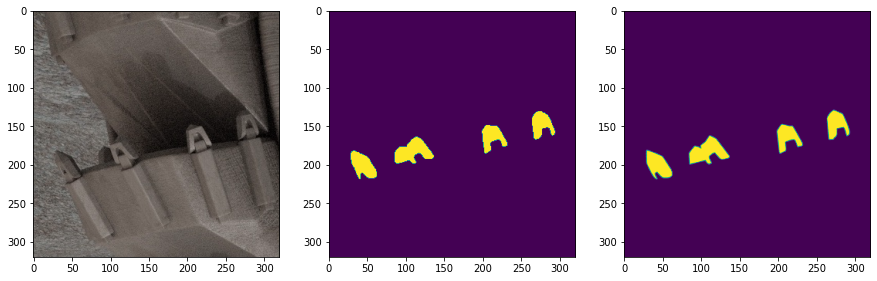

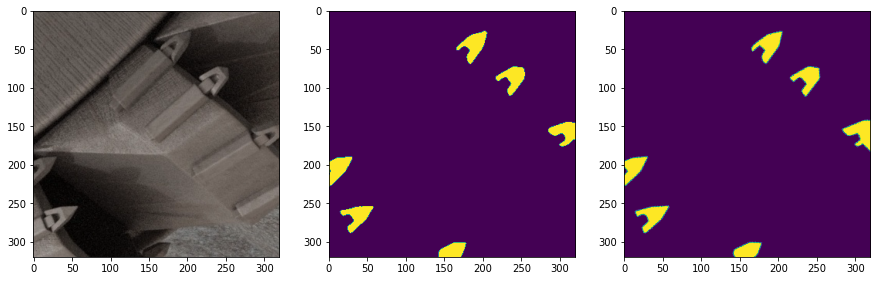

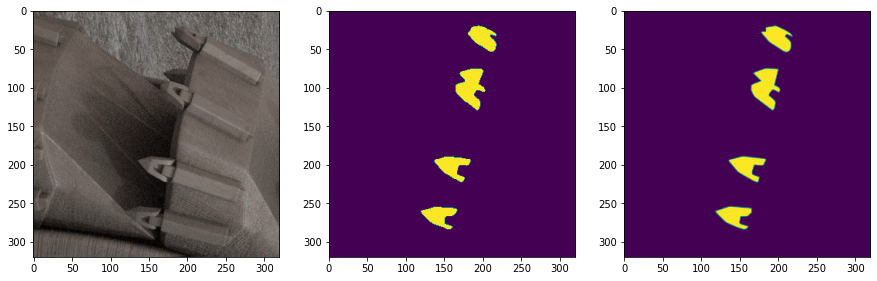

In [248]:
for hih in range(3):
  im_id = hih
  #print(pred[im_id, ..., 0].shape)
  fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 10))
  axes[0].imshow(x[im_id])
  axes[1].imshow(pred[im_id, ..., 0]>0.5)
  axes[2].imshow(y[im_id][:,:,0])

plt.show()

## Черновик (проверки свои)

In [ ]:
def dice_coef(y_true, y_pred):
    smooth = 0.
    y_true_f = y_true.flatten()
    #y_pred_f = y_true.flatten()
    intersection = np.sum(y_true_f * y_true_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_true_f) + smooth)

In [ ]:
sredn_dice_coef = 0
for im_id in range(10):
  y_true = y[im_id][:,:,0]
  y_pred = pred[im_id, ..., 0]
  sredn_dice_coef += dice_coef(y_true, y_true)
  #print(dice_coef(y_true, y_true))

print(round(sredn_dice_coef/(10)*100,2))

96.04


In [ ]:
def compute_dice_coefficient(mask_gt, mask_pred):
  """Computes soerensen-dice coefficient.

 compute the soerensen-dice coefficient between the ground truth mask `mask_gt`
 and the predicted mask `mask_pred`.

 Args:
 mask_gt: 3-dim Numpy array of type bool. The ground truth mask.
 mask_pred: 3-dim Numpy array of type bool. The predicted mask.

 Returns:
 the dice coeffcient as float. If both masks are empty, the result is NaN.
 """
  volume_sum = mask_gt.sum() + mask_pred.sum()
  if volume_sum == 0:
    return np.NaN
  volume_intersect = (mask_gt * mask_pred).sum()
  return 2*volume_intersect / volume_sum 

In [ ]:
sredn_dice_coef = 0
range_value = 10
for im_id in range(range_value):
  y_true_ = y[im_id][:,:,0]#> 0.5).astype(int)
  #y_pred_ = (y[im_id][:,:,0] > 0.5).astype(int)
  y_pred_ = (pred[im_id, ..., 0] > 0.5).astype(int)
  sredn_dice_coef += dice_coef(y_true=y_true_, y_pred=y_pred_)
  print(dice_coef(y_true=y_true_, y_pred=y_pred_))

print(round(sredn_dice_coef/(range_value)*100,2))

0.9589332090034853
0.9601089665356757
0.9585992420766332
0.9649972391934436
0.958074427096198
0.9590283954243015
0.9601089665356757
0.96160793110153
0.9622032887188139
0.9600981099391672
96.04


In [ ]:
# load your data
x_train, y_train, x_val, y_val = load_data(...)

# preprocess input
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)



# fit model
# if you use data generator use model.fit_generator(...) instead of model.fit(...)
# more about `fit_generator` here: https://keras.io/models/sequential/#fit_generator
model.fit(
   x=x_train,
   y=y_train,
   batch_size=16,
   epochs=100,
   validation_data=(x_val, y_val),
)

# Выводим маски на основе отложенной выборки

In [ ]:
from google.colab import files
uploaded_test = files.upload()

Saving test.zip to test.zip


In [ ]:
print(os.listdir("/content/sample_data/BTS Test/"))

# Any results you write to the current directory are saved as output.
import zipfile
with zipfile.ZipFile('/content/test.zip', 'r') as zip_obj:
   # Extract all the contents of zip file in current directory
   zip_obj.extractall('/content/sample_data/BTS Test/')
    
print('After zip extraction:')
print(os.listdir("/content/sample_data/BTS Test/"))

['dataset_aug', 'group_of_odin.txt', 'final_df.csv', 'dataset']
After zip extraction:
['imgs', 'dataset_aug', 'group_of_odin.txt', 'final_df.csv', 'dataset']


In [ ]:
import os
dirname = '/content/sample_data/BTS Test/imgs'
files_test = os.listdir(dirname)
print(files_test[:5])

['Image0188.jpg', 'Image0165.jpg', 'Image0163.jpg', 'Image0226.jpg', 'Image0235.jpg']


In [ ]:
def hor_ver_stak(x_test_0):
    x_test_1 = np.hstack((x_test_0[0][:,:-50,:], x_test_0[1][:,50:-50,:], x_test_0[2][:,42:,:]))
    x_test_2 = np.hstack((x_test_0[3][:,:-50,:], x_test_0[4][:,50:-50,:], x_test_0[5][:,42:,:]))
    x_test_3 = np.vstack((x_test_1[:-32,:,:], x_test_2[32:,:,:]))
    return x_test_3

## Смотрим финальные тестовые фотки и их маски

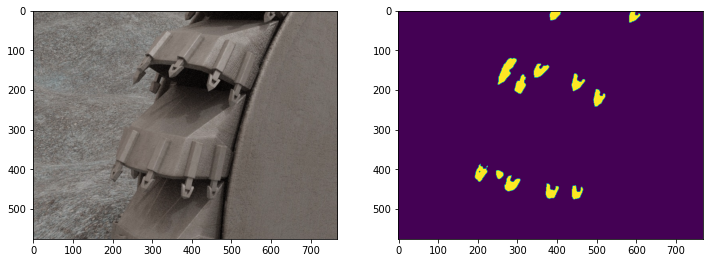

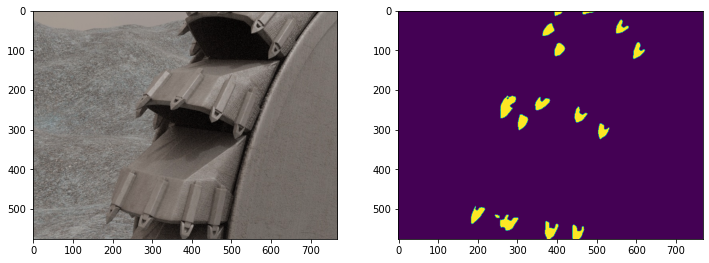

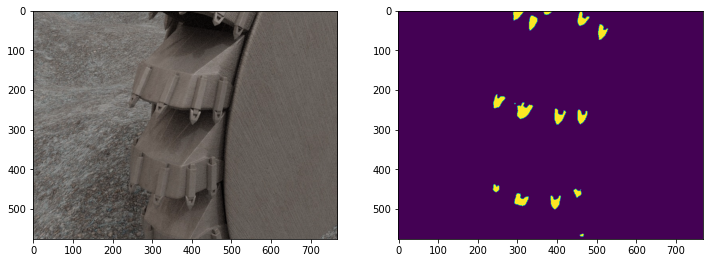

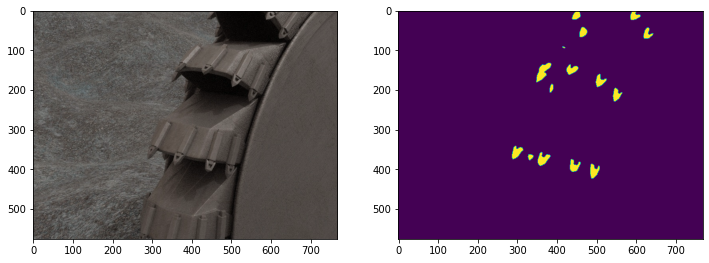

In [257]:
#в тесте 80 изображений

for imm in range(41,45):
  img = cv2.imread('/content/sample_data/BTS Test/imgs/{}'.format(files_test[imm]))
    
  x_test_0 = []
  x_test_0 += [img[:320,:320,:]]
  x_test_0 += [img[:320,220:540,:]]
  x_test_0 += [img[:320,-320:,:]]
  x_test_0 += [img[-320:,:320,:]]
  x_test_0 += [img[-320:,220:540,:]]
  x_test_0 += [img[-320:,-320:,:]]

  x_test_0 = np.array(x_test_0) / 255.
  pred_0 = model.predict(x_test_0)

  x_test_3 = hor_ver_stak(x_test_0)
  y_test_3 = hor_ver_stak(pred_0)
  #print(x_test_3.shape)
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

  axes[0].imshow(x_test_3)
  axes[1].imshow(y_test_3[:,:,0]>0.5)

  plt.show()
    

## Сохраняем маски

In [252]:
for imm in range(80):
  img = cv2.imread('/content/sample_data/BTS Test/imgs/{}'.format(files_test[imm]))
    
  x_test_0 = []
  x_test_0 += [img[:320,:320,:]]
  x_test_0 += [img[:320,220:540,:]]
  x_test_0 += [img[:320,-320:,:]]
  x_test_0 += [img[-320:,:320,:]]
  x_test_0 += [img[-320:,220:540,:]]
  x_test_0 += [img[-320:,-320:,:]]

  x_test_0 = np.array(x_test_0) / 255.
  pred_0 = model.predict(x_test_0)

  x_test_3 = hor_ver_stak(x_test_0)
  y_test_3 = hor_ver_stak(pred_0)*255
  #print(x_test_3.shape)
  print(files_test[imm], files_test[imm][:-4])
  cv2.imwrite('/content/sample_data/BTS Test/final_masks/format jpg/{}'.format(files_test[imm][:-4]+'.jpg'), y_test_3)
  cv2.imwrite('/content/sample_data/BTS Test/final_masks/format png/{}'.format(files_test[imm][:-4]+'.png'), y_test_3)


Image0232.jpg Image0232
Image0234.jpg Image0234
Image0183.jpg Image0183
Image0205.jpg Image0205
Image0218.jpg Image0218
Image0189.jpg Image0189
Image0239.jpg Image0239
Image0202.jpg Image0202
Image0172.jpg Image0172
Image0212.jpg Image0212
Image0190.jpg Image0190
Image0216.jpg Image0216
Image0227.jpg Image0227
Image0180.jpg Image0180
Image0193.jpg Image0193
Image0219.jpg Image0219


In [253]:
import zipfile 
zname=r'/content/sample_data/BTS Test/final_masks.zip' #создаем переменную - название и местоположение файла
newzip=zipfile.ZipFile(zname,'w')
for imm in files_test:
  newzip.write(r'/content/sample_data/BTS Test/final_masks/format png/{}'.format(imm[:-4]+'.png'))
  newzip.write(r'/content/sample_data/BTS Test/final_masks/format jpg/{}'.format(imm[:-4]+'.jpg'))
newzip.close()

In [ ]:
import zipfile 
zname=r'/content/sample_data/BTS Test/dataset_aug_ch1.zip' #создаем переменную - название и местоположение файла
newzip=zipfile.ZipFile(zname,'w')
for numim in range(1440):
  img_name, mask_rle = df.iloc[numim]
  newzip.write(r'/content/sample_data/BTS Test/dataset_aug/imgs/{}'.format(img_name))
  newzip.write(r'/content/sample_data/BTS Test/dataset_aug/masks/{}'.format(mask_rle))
newzip.close()

zname=r'/content/sample_data/BTS Test/dataset_aug_ch2.zip' #создаем переменную - название и местоположение файла
newzip=zipfile.ZipFile(zname,'w')
for numim in range(1440,2*1440):
  img_name, mask_rle = df.iloc[numim]
  newzip.write(r'/content/sample_data/BTS Test/dataset_aug/imgs/{}'.format(img_name))
  newzip.write(r'/content/sample_data/BTS Test/dataset_aug/masks/{}'.format(mask_rle))
newzip.close()

zname=r'/content/sample_data/BTS Test/dataset_aug_ch3.zip' #создаем переменную - название и местоположение файла
newzip=zipfile.ZipFile(zname,'w')
for numim in range(2*1440,3*1440):
  img_name, mask_rle = df.iloc[numim]
  newzip.write(r'/content/sample_data/BTS Test/dataset_aug/imgs/{}'.format(img_name))
  newzip.write(r'/content/sample_data/BTS Test/dataset_aug/masks/{}'.format(mask_rle))
newzip.close()

zname=r'/content/sample_data/BTS Test/dataset_aug_ch4.zip' #создаем переменную - название и местоположение файла
newzip=zipfile.ZipFile(zname,'w')
for numim in range(3*1440,4*1440):
  img_name, mask_rle = df.iloc[numim]
  newzip.write(r'/content/sample_data/BTS Test/dataset_aug/imgs/{}'.format(img_name))
  newzip.write(r'/content/sample_data/BTS Test/dataset_aug/masks/{}'.format(mask_rle))
newzip.close()

# Очистка памяти ОЗУ и Видеокарты

In [ ]:
!apt install psmisc

Reading package lists... Done
Building dependency tree       
Reading state information... Done
psmisc is already the newest version (23.1-1ubuntu0.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [ ]:
!sudo fuser /dev/nvidia*

/dev/nvidia0:         2653m
/dev/nvidiactl:       2653m
/dev/nvidia-uvm:      2653


In [ ]:
!kill -9 2653